In [0]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


#### Getting the data

In [4]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


#### Explore visual data

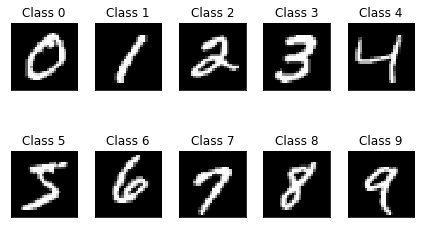

In [5]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [6]:
print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


### 2. Define model

#### Generator

In [7]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 7x7x256
generator.add(Dense(7*7*128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((7, 7, 128)))

# Conv 1: 14x14x128
generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# Conv 2: 28x28x64
generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# # Conv 3: 28x28x32
# generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
# generator.add(BatchNormalization(momentum=0.8))
# generator.add(ReLU(0.2))

# Conv 4: 28x28x1
generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='tanh'))

W0817 15:11:01.140680 140561877612416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 15:11:01.182872 140561877612416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 15:11:01.282903 140561877612416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0817 15:11:01.305155 140561877612416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0817 15:11:01.344659 140561877612416 deprecation_wra

#### Generator model visualization

In [8]:
# prints a summary representation of your model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
__________

#### Discriminator

In [0]:
# Discriminator network
discriminator = Sequential()

# Conv 1: 14x14x64
discriminator.add(Conv2D(32, kernel_size=3, strides=2, padding='same',
                         input_shape=(28, 28, 1), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

#### Discriminator model visualization

In [10]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 128)         512       
__________

### 3. Compile model

#### Compile discriminator

In [11]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

W0817 15:11:19.735485 140561877612416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0817 15:11:19.746148 140561877612416 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Combined network

We connect the generator and the discriminator to make a DCGAN.

In [0]:
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

#### GAN model vizualization

In [13]:
# prints a summary representation of your model
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         726401    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 95489     
Total params: 821,890
Trainable params: 726,209
Non-trainable params: 95,681
_________________________________________________________________


### 4. Fit model

epoch = 1/100, d_loss=0.183, g_loss=4.813                                                                                                     


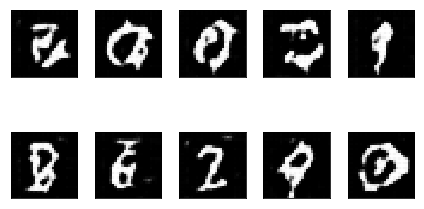

epoch = 2/100, d_loss=0.330, g_loss=4.111                                                                                                     
epoch = 3/100, d_loss=0.230, g_loss=3.904                                                                                                     
epoch = 4/100, d_loss=0.451, g_loss=3.641                                                                                                     
epoch = 5/100, d_loss=0.468, g_loss=2.837                                                                                                     
epoch = 6/100, d_loss=0.234, g_loss=3.757                                                                                                     
epoch = 7/100, d_loss=0.303, g_loss=3.260                                                                                                     
epoch = 8/100, d_loss=0.326, g_loss=2.995                                                                                                     

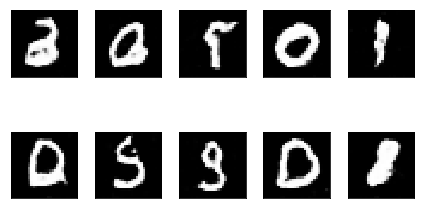

epoch = 12/100, d_loss=0.326, g_loss=2.846                                                                                                     
epoch = 13/100, d_loss=0.331, g_loss=2.724                                                                                                     
epoch = 14/100, d_loss=0.365, g_loss=2.669                                                                                                     
epoch = 15/100, d_loss=0.310, g_loss=2.864                                                                                                     
epoch = 16/100, d_loss=0.281, g_loss=2.970                                                                                                     
epoch = 17/100, d_loss=0.367, g_loss=2.492                                                                                                     
epoch = 18/100, d_loss=0.274, g_loss=2.937                                                                                              

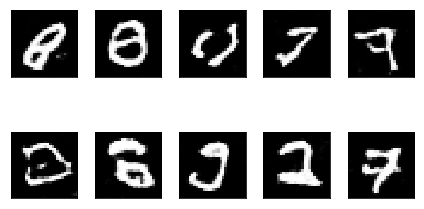

epoch = 22/100, d_loss=0.295, g_loss=3.306                                                                                                     
epoch = 23/100, d_loss=0.274, g_loss=3.148                                                                                                     
epoch = 24/100, d_loss=0.389, g_loss=2.752                                                                                                     
epoch = 25/100, d_loss=0.259, g_loss=3.093                                                                                                     
epoch = 26/100, d_loss=0.278, g_loss=3.160                                                                                                     
epoch = 27/100, d_loss=0.348, g_loss=3.255                                                                                                     
epoch = 28/100, d_loss=0.237, g_loss=3.713                                                                                              

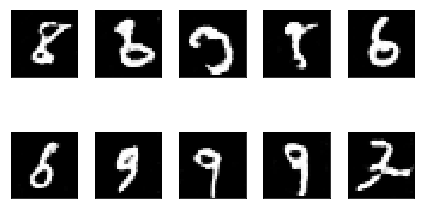

epoch = 32/100, d_loss=0.272, g_loss=3.259                                                                                                     
epoch = 33/100, d_loss=0.311, g_loss=3.095                                                                                                     
epoch = 34/100, d_loss=0.255, g_loss=3.474                                                                                                     
epoch = 35/100, d_loss=0.239, g_loss=3.561                                                                                                     
epoch = 36/100, d_loss=0.281, g_loss=3.401                                                                                                     
epoch = 37/100, d_loss=0.563, g_loss=3.554                                                                                                     
epoch = 38/100, d_loss=0.244, g_loss=3.105                                                                                              

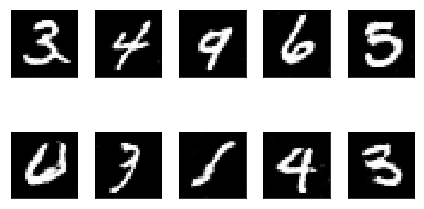

epoch = 42/100, d_loss=0.258, g_loss=3.239                                                                                                     
epoch = 43/100, d_loss=0.265, g_loss=3.301                                                                                                     
epoch = 44/100, d_loss=0.272, g_loss=4.706                                                                                                     
epoch = 45/100, d_loss=0.215, g_loss=3.737                                                                                                     
epoch = 46/100, d_loss=0.238, g_loss=3.487                                                                                                     
epoch = 47/100, d_loss=0.207, g_loss=3.916                                                                                                     
epoch = 48/100, d_loss=0.367, g_loss=3.539                                                                                              

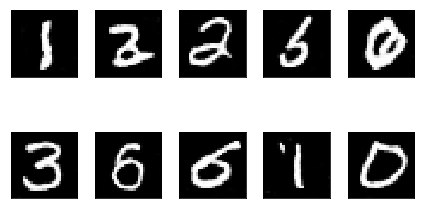

epoch = 52/100, d_loss=1.531, g_loss=4.459                                                                                                     
epoch = 53/100, d_loss=0.216, g_loss=3.750                                                                                                     
epoch = 54/100, d_loss=1.518, g_loss=3.638                                                                                                     
epoch = 55/100, d_loss=0.254, g_loss=3.680                                                                                                     
epoch = 56/100, d_loss=0.246, g_loss=3.464                                                                                                     
epoch = 57/100, d_loss=1.404, g_loss=2.893                                                                                                     
epoch = 58/100, d_loss=0.207, g_loss=3.760                                                                                              

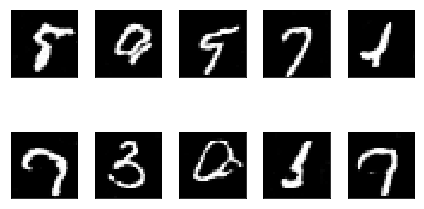

epoch = 62/100, d_loss=0.348, g_loss=2.974                                                                                                     
epoch = 63/100, d_loss=0.269, g_loss=3.421                                                                                                     
epoch = 64/100, d_loss=0.260, g_loss=3.869                                                                                                     
epoch = 65/100, d_loss=0.644, g_loss=3.115                                                                                                     
epoch = 66/100, d_loss=0.531, g_loss=4.988                                                                                                     
epoch = 67/100, d_loss=0.566, g_loss=3.901                                                                                                     
epoch = 68/100, d_loss=0.404, g_loss=4.068                                                                                              

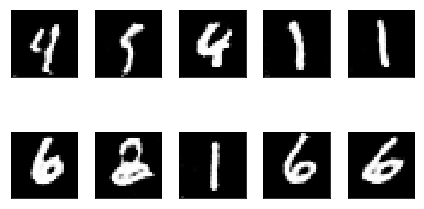

epoch = 72/100, d_loss=0.208, g_loss=3.723                                                                                                     
epoch = 73/100, d_loss=0.407, g_loss=3.634                                                                                                     
epoch = 74/100, d_loss=0.264, g_loss=3.436                                                                                                     
epoch = 75/100, d_loss=0.422, g_loss=2.918                                                                                                     
epoch = 76/100, d_loss=0.245, g_loss=3.433                                                                                                     
epoch = 77/100, d_loss=0.288, g_loss=3.900                                                                                                     
epoch = 78/100, d_loss=0.205, g_loss=4.087                                                                                              

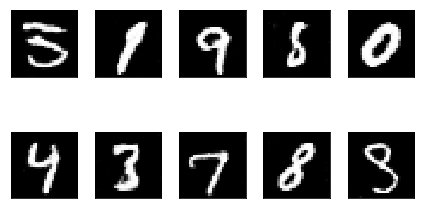

epoch = 82/100, d_loss=0.431, g_loss=5.260                                                                                                     
epoch = 83/100, d_loss=0.257, g_loss=3.274                                                                                                     
epoch = 84/100, d_loss=0.208, g_loss=3.821                                                                                                     
epoch = 85/100, d_loss=0.214, g_loss=4.132                                                                                                     
epoch = 86/100, d_loss=0.274, g_loss=3.243                                                                                                     
epoch = 87/100, d_loss=0.196, g_loss=4.142                                                                                                     
epoch = 88/100, d_loss=0.296, g_loss=3.481                                                                                              

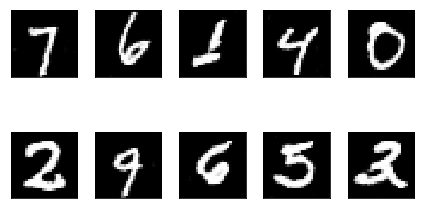

epoch = 92/100, d_loss=0.217, g_loss=3.612                                                                                                     
epoch = 93/100, d_loss=1.341, g_loss=8.250                                                                                                     
epoch = 94/100, d_loss=0.212, g_loss=3.781                                                                                                     
epoch = 95/100, d_loss=0.387, g_loss=3.516                                                                                                     
epoch = 96/100, d_loss=0.185, g_loss=4.550                                                                                                     
epoch = 97/100, d_loss=0.215, g_loss=3.969                                                                                                     
epoch = 98/100, d_loss=0.200, g_loss=4.112                                                                                              

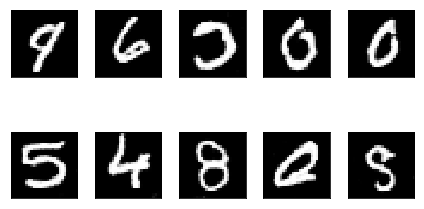

In [15]:
epochs = 100
batch_size = 128
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch, y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        d_g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

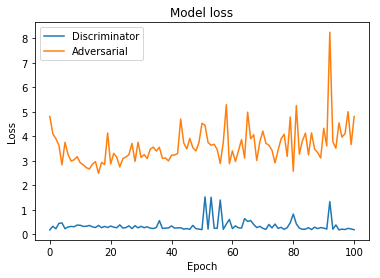

In [16]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='best')
plt.show()